In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.stats import kde
from scipy import stats
#import seaborn as sns
#import scipy.stats as stats
from IPython.display import HTML, display
#import VolvoTrucksAnalytics as VTA

#2 Gammas Fix later
#from scipy.stats import gamma
#from scipy.stats.distributions import gamma
#from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KernelDensity
#from scipy.stats import kde
#from scipy.special import psi, polygamma
#from scipy.optimize import newton

In [20]:
#The two truck data set paths are set here.
truck1csv = "../data/trucks/truck1.csv"
truck2csv = "../data/trucks/truck2.csv"

#The two column header dictonary paths are set here.
truck1dictcsv = "../data/dictionary/truck1dict.csv"
truck2dictcsv = "../data/dictionary/truck2dict.csv"

#Number of records desired from the data set.
numberOfRecords = 100

#If the number of values that are NOT Na type pass this percentage, the row will be deleted
rowNaNThresholdPercent = 75

#Create column conversion dictionaries from CSV files.
truck1dict={}
truck2dict={}
with open(truck1dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck1dict.update({row[0]:row[1]})
        
with open(truck2dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck2dict.update({row[0]:row[1]})
        
def readCsv(truck):
    return pd.read_csv(truck, header = [0])
    
def cullUtcCols(truckData):
    noUTC = truckData.drop(["UTC hour", "UTC minute", "UTC second", "UTC month", "UTC day", "UTC year"], axis = 1)
    return noUTC

"""Takes a DataFrame and a conversion dictionary as parameters;
    uses the dictionary to rename all matching columns then returns the changed DataFrame."""
def renameColumns(dataFrame, dictionary):
    return dataFrame.rename(columns = dictionary)

"""Finds threshold of Non-NA type using percentage and deletes rows."""
def removeUnnecessaryRows(dataFrame):
    length = len(dataFrame.columns)
    TValue = (rowNaNThresholdPercent / 100) * length
    print("Threshold value: " + str(int(TValue)))
    return dataFrame.dropna(thresh = int(TValue))

"""Finds columns with all Na types and deletes them."""
def removeUnnecessaryColumns(dataFrame):
    return dataFrame.dropna(axis=1, how='all')

# NOTE: The following function is unused in this notebook, but it can be used to convert CSV files into
# conversion dictionaries i.e. creating the column rename dictionaries, which was manually done in the
# previous block manually.

"""Creates a Python dictionary from a pre-defined CSV dictionary.
This will only look at the first two columns of the given CSV file."""
def createPythonDictionary(dictionaryCSV):
    # Initialize the resulting dictionary.
    dictResult = {}
    
    # Opens the passed in CSV which defines the rename dictionary and iterates through it to store each value into a Python dictionary.
    with open(dictionaryCSV, 'r') as f:
        for row in csv.reader(f):
            dictResult.update({row[0]:row[1]})
    return dictResult


#For the function divideByDay() make sure to pass in a DataFrame of a truck. 
#If you want specific column of data then just specify it by using quotation and the accurate name of the column. 
#Example: This line will get daily averages for all columns: print(divideByDay(truck1data) 
#This line will get daily average of speed: print(divideByDay(truck1data, "Speed (km/hr)"))

def divideByDay(truck_df, byday_df=None):
    dates = []
    #truck_df = truck_df.head()
    for index, tdata in truck_df.iterrows():
        dates.append(tdata['Time (DateTime)'].split(' ')[0])
        #print(index, dates)
        
    truck_df['Time (DateTime)'] = dates
    
    if(byday_df):
        byday_df = truck_df.groupby('Time (DateTime)')[byday_df].mean()
    else:
        byday_df = truck_df.groupby('Time (DateTime)').mean()

    return byday_df

## Same use as divideByDay() but needs second parameter!! If no parameter given, error will be thrown.
def outlierDetection(truck_df, column_attribute):
    
    iterateData = 0
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    iqr = fiveNum[3] - fiveNum[1]
    low_outl = fiveNum[1] - (1.5 * iqr)
    high_outl = fiveNum[3] + (1.5 * iqr)
    print("Before Outlier Deletion: " + str(fiveNum))
    print("Low bound: " + str(low_outl))
    print("High bound: " + str(high_outl))
 
    truck_df = truck_df[(truck_df[column_attribute] > low_outl)]
    truck_df = truck_df[(truck_df[column_attribute] < high_outl)]
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    #iqr = fiveNum[3] - fiveNum[1]
    #low_outl = fiveNum[1] - (1.5 * iqr)
    #high_outl = fiveNum[3] + (1.5 * iqr)
    print("After Outlier Deletion: " + str(fiveNum))

    sns.boxplot(x=truck_df[column_attribute], showfliers=False)
    
    return truck_df

def culTempData(truck_df):
    trucks_df.drop(['Time', 'C_1115_1_Alternator_250A', 'C_1115_2_BattOut_100A', 'C_1115_3_Fridge_20A' ,'EngineAirIntakeTemp_BB1_X_E', 'C_1115_4_Trailer_50A', 'C_1115_5_Inventer_100A','asu_UreaTankTemp', 'EngExhaustGasTemp', 'TotalVehicleDistanceHighRes', 'EngineSpeed', 'WheelBasedVehicleSpeed', 'EngineKeyPosition', 'SteeringWheelAngle1', 'BarometricPressure_BB1_X_E', 'CPU load', 'UTC hour', 'UTC minute', 'UTC second', 'UTC month', 'UTC day', 'UTC year', 'GPS altitude', 'GPS speed', 'BoostPressure', 'VehicleSpeed', 'CruiseCtrlSetSpeed','VehicleWeightVP15', 'RoadInclinationVP15', 'TransOilPress', 'TransOilLevel', 'ActualEnginePercentTorque', 'ActualEnginePercentTorqueHiRes', 'DrvrDemandEngPercentTorque', 'EngDemandPercentTorque', 'EnginePercentLoadAtCurrentSpd', 'EngineOilLevel', 'EngineOilPressure', 'EngDslPrtclateFilterIntakePress', 'EngIntakeManifold1Press', 'EngineCoolantTemp_stat', 'EngineOilTemperature', 'EngIntakeManifold1Temp', 'TransmissionOilTemp'], axis=1)
    
    return truck_df



In [21]:
truck1data = readCsv(truck1csv)
truck1data = cullUtcCols(truck1data)
truck1data = removeUnnecessaryRows(truck1data)
truck1data = renameColumns(truck1data, truck1dict)
truck1data = removeUnnecessaryColumns(truck1data)

truck2data = readCsv(truck2csv)
truck2data = cullUtcCols(truck2data)
truck2data = removeUnnecessaryRows(truck2data)
truck2data = renameColumns(truck1data, truck2dict)
truck2data = removeUnnecessaryColumns(truck2data)

Threshold value: 33
Threshold value: 30


# I want to test my hypothesis that external temperature affects engine performance.

### After some research, the main engine part that is affected by temperature is the turbocharger, which passes more air to the cylinder which can be mixed with more fuel to create more power. When the temperature is too hot, it is harder for the turbocharger to work resulting in less performance.

##### So the two columns I want to focus on are Turbo Speed and Outside Air Temperature

# Null Hypothesis: Outside Air Temperature = Turbo Speed

# Alternative Hypothesis: Outside Air Temperature ≠ Turbo Speed

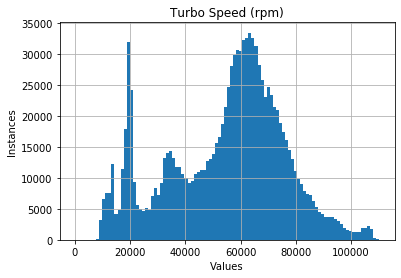

In [4]:
##### Let's take a look at the distributions:
plt.title("Turbo Speed (rpm)")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(truck1data['Turbo Speed (rpm)']).hist(bins=100)

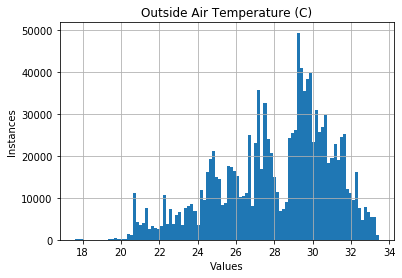

In [5]:
plt.title("Outside Air Temperature (C)")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(truck1data['Outside Air Temperature (C)']).hist(bins=100)

In [6]:
#Before normalization
stats.pearsonr(truck1data['Turbo Speed (rpm)'], truck1data['Outside Air Temperature (C)'])

(nan, 1.0)

##### They appear to be bi-modal distributions. So I'm going to normalize them using the Central Limit Theorem

In [7]:
turbo_points = []         # Make empty list to hold point estimates
for x in range(0,1000):         # Generate 1000 samples
    turbo_points.append(truck1data['Turbo Speed (rpm)'].sample(n=500).mean())

In [8]:
air_points = []
for i in range(0,1000):
    air_points.append(truck1data['Outside Air Temperature (C)'].sample(n=500).mean())

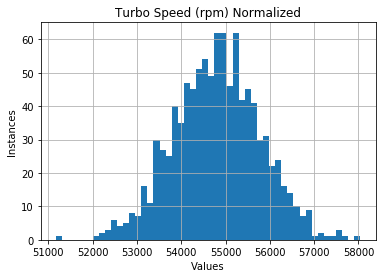

In [9]:
plt.title("Turbo Speed (rpm) Normalized")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(turbo_points).hist(bins=50)

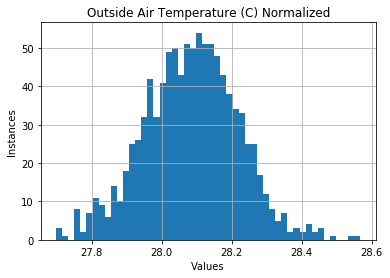

In [10]:
plt.title("Outside Air Temperature (C) Normalized")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(air_points).hist(bins=50)

In [11]:
stats.pearsonr(turbo_points, air_points)

(-0.01443574086022436, 0.6484252039220186)

##### The p-value is greater than .05, therefore,  so we accept the null hypothesis that the outside air temperature does affect the turbo speed. 

##### Now lets test Truck 2.

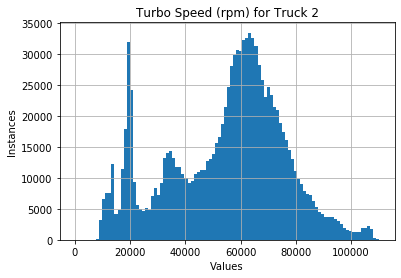

In [12]:
##### Let's take a look at the distributions:
plt.title("Turbo Speed (rpm) for Truck 2")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(truck2data['Turbo Speed (rpm)']).hist(bins=100)

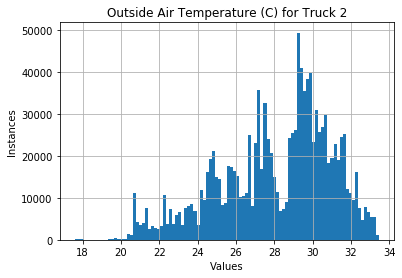

In [13]:
plt.title("Outside Air Temperature (C) for Truck 2")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(truck2data['Outside Air Temperature (C)']).hist(bins=100)

In [14]:
#Before normalization
stats.pearsonr(truck2data['Turbo Speed (rpm)'], truck2data['Outside Air Temperature (C)'])

(nan, 1.0)

In [15]:
turbo_points2 = []         # Make empty list to hold point estimates
for x in range(0,1000):         # Generate 1000 samples
    turbo_points2.append(truck2data['Turbo Speed (rpm)'].sample(n=500).mean())

In [16]:
air_points2 = []
for i in range(0,1000):
    air_points2.append(truck2data['Outside Air Temperature (C)'].sample(n=500).mean())

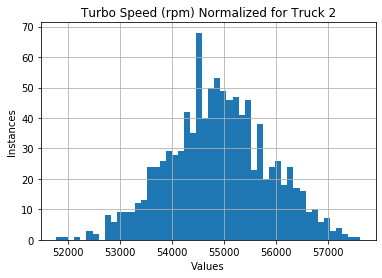

In [17]:
plt.title("Turbo Speed (rpm) Normalized for Truck 2")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(turbo_points2).hist(bins=50)

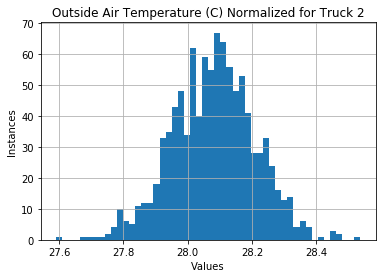

In [18]:
plt.title("Outside Air Temperature (C) Normalized for Truck 2")
plt.ylabel("Instances")
plt.xlabel("Values")
pd.Series(air_points2).hist(bins=50)

In [19]:
stats.pearsonr(turbo_points2, air_points2)

(-0.0528238044458318, 0.09501599378699249)

##### The p-value is greater than .05, therefore,  so we accept the null hypothesis that the outside air temperature does affect the turbo speed. 

